Loaded 10 images from folder:
/home/fizzer/enph353_git/beep-boop/labs/lab5/enph353_cnn_lab/resized_numbers
Loaded 26 images from folder:
/home/fizzer/enph353_git/beep-boop/labs/lab5/enph353_cnn_lab/resized_letters
Total examples: 3004
Training examples: 2404
Test examples: 600
X shape:(3004, 137, 106, 3)
Y shape:(3004, 36)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 135, 104, 32)      896       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 67, 52, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 65, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 32, 25, 64)        0         
__________________________________________________________

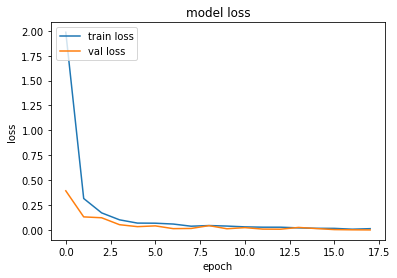

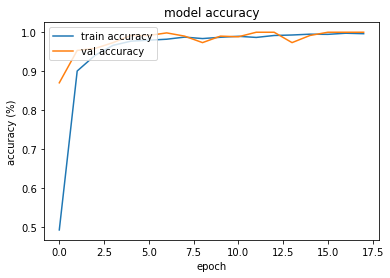

The license plate reads:ZD70


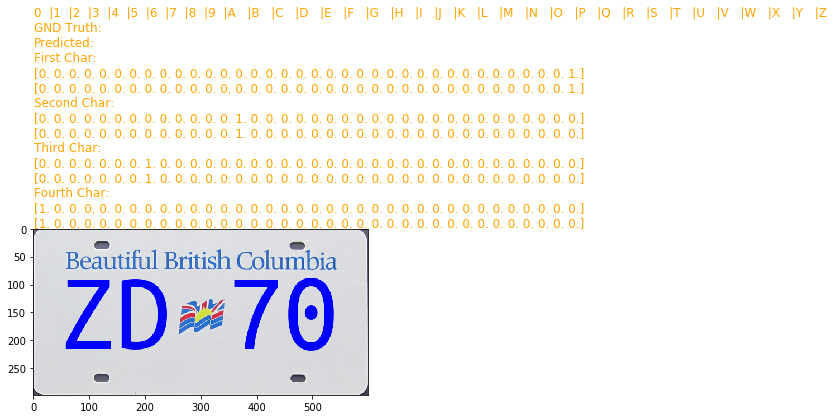

In [64]:
import math
import numpy as np
import re
import os, random

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image
import cv2 

from ipywidgets import interact
import ipywidgets as ipywidgets

from keras import layers
from keras import models
from keras import optimizers

from keras import backend
from keras.utils import *

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn
import pandas as pd

np.set_printoptions(linewidth=np.inf)

# Constants
LETTER_PATH = '/home/fizzer/enph353_git/beep-boop/labs/lab5/enph353_cnn_lab/resized_letters'
NUMBER_PATH = '/home/fizzer/enph353_git/beep-boop/labs/lab5/enph353_cnn_lab/resized_numbers'
PLATE_PATH = '/home/fizzer/enph353_git/beep-boop/labs/lab5/enph353_cnn_lab/plates'
H = 298
W = 600
NUMBER_OF_LABELS = 36                # Number of different labels, 10 + 26 = 36
CONFIDENCE_THRESHOLD = 0.05          # How accurate the training model is
VALIDATION_SPLIT = 0.2               # Portion of dataset to be used in validation
LEARNING_RATE = 1e-4                 # Rate of how each step propagates


def files_in_folder(folder_path):
  '''
  Returns a list of strings where each entry is a file in the folder_path.
  
  Parameters
  ----------
  
  folder_path : str
     A string to folder for which the file listing is returned.
     
  '''
  files_A = !ls "{folder_path}"
  # The files when listed from Google Drive have a particular format. They are
  # grouped in sets of 4 and have spaces and tabs as delimiters.
  
  # Split the string listing sets of 4 files by tab and space and remove any 
  # empty splits.
  files_B = [list(filter(None, re.split('\t|\s', files))) for files in files_A]
  
  # Concatenate all splits into a single sorted list
  files_C = []
  for element in files_B:
    files_C = files_C + element
  files_C.sort()
  
  return files_C


def convert_to_one_hot(Y,C):
    '''
    Returns an array of one hot encoding for dataset Y, with size C.
    
    Parameters
    ----------
    
    Y : array
        An array of the dataset.
        
    C : int
        The size of the array.
        
    '''
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def displayPlate(index):
    '''
    Displays image of the plate with the specified index.
    
    Parameters
    ----------
    
    index : int
        The index of image of plate to be displayed.
        
    '''
    
    img = np.array(Image.open(f'{plate_folder}/{plates[index]}'))
    
    # Gives the four indices that correspond to the four segments of the plate
    plateIndex = index * 4 + 36
    segIndex = np.array([plateIndex ,plateIndex + 1 ,plateIndex + 2, plateIndex + 3])

    seg0_aug = np.expand_dims(X_charset[segIndex[0]], axis=0)
    seg1_aug = np.expand_dims(X_charset[segIndex[1]], axis=0)
    seg2_aug = np.expand_dims(X_charset[segIndex[2]], axis=0)
    seg3_aug = np.expand_dims(X_charset[segIndex[3]], axis=0)
    
    y0_predict = np.around(conv_model.predict(seg0_aug)[0], decimals=2)
    y1_predict = np.around(conv_model.predict(seg1_aug)[0], decimals=2)
    y2_predict = np.around(conv_model.predict(seg2_aug)[0], decimals=2)
    y3_predict = np.around(conv_model.predict(seg3_aug)[0], decimals=2)
    
    plt.imshow(img)
    caption = ('0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |A   |B   |C   |D   |E   |F   |G   |H   |I   |J   |K   |L   |M   |N   |O   |P   |Q   |R   |S   |T   |U   |V   |W   |X   |Y   |Z\n' 
               + 
              'GND Truth:\nPredicted:\nFirst Char:\n{}\n{}\nSecond Char:\n{}\n{}\nThird Char:\n{}\n{}\nFourth Char:\n{}\n{}'. 
              format(str(Y_charset[segIndex[0]]), str(y0_predict), str(Y_charset[segIndex[1]]), str(y1_predict), str(Y_charset[segIndex[2]]), str(y2_predict), str(Y_charset[segIndex[3]]), str(y3_predict)))
    plt.text(0.5, 1.2, caption, color='orange', fontsize='12', verticalalignment='bottom')
    

    c0 = chr(np.argmax(y0_predict) + 55)
    c1 = chr(np.argmax(y1_predict) + 55)
    c2 = chr(np.argmax(y2_predict) + 48)
    c3 = chr(np.argmax(y3_predict) + 48)
    
    print("The license plate reads:" + str(c0+c1+c2+c3))

 
# Reinitialize model parameters.
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers:
        
        # Look for the layer with attribute = 'kernel_initializer' and run session
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

            
# Generate confusion matrix and plot it.
def plotConfusionMatrix():
    mapping = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    y_truth = np.array([mapping[y]
                      for y in Y_charset_orig[0]])
    
    y_predict = np.array([mapping[np.argmax(conv_model.predict(np.expand_dims(x, axis = 0))[0])]
                    for x in X_charset[:]])
    
    cm = confusion_matrix(y_truth, y_predict)
    
    df_cm = pd.DataFrame(cm, index = [i for i in mapping],
                  columns = [i for i in mapping])
    plt.figure(figsize = (20,15))
    sn.heatmap(df_cm, annot=True)


# Specifying paths to folder
letter_folder = LETTER_PATH
number_folder = NUMBER_PATH
plate_folder = PLATE_PATH

# Generating a list of files in the specified folder
letters = files_in_folder(letter_folder)
numbers = files_in_folder(number_folder)
plates = files_in_folder(plate_folder)

random.shuffle(plates)

# Open the images of numbers and label each number. NOTE: '0' corresponds to label 0, '1' corresponds 
# to label 1, etc.
numberSet = np.array([[np.array(Image.open(f'{number_folder}/{n}'))[:,:,0:3], ord(os.path.splitext(n)[0]) - 48]
                      for n in numbers[:]])
print("Loaded {:} images from folder:\n{}".format(numberSet.shape[0], number_folder))

# Open the images of letters and label each letter. NOTE: A corresponds to label 10, B to label 11, etc.
letterSet = np.array([[np.array(Image.open(f'{letter_folder}/{l}'))[:,:,0:3], ord(os.path.splitext(l)[0]) - 55]
                      for l in letters[:]])
print("Loaded {:} images from folder:\n{}".format(letterSet.shape[0], letter_folder))

# Concatenate the two data sets to form the X-axis (i.e. character set). Default axis is 0
charSet = np.concatenate((numberSet, letterSet))


# Open images of plates and label each letter on each plate
for p in plates[:]:
    # Get plate name
    plate_name = os.path.splitext(p)[0][6:10]
    
    # Create arrays for separate characters and label them
    firstChar = np.array([[np.array(Image.open(f'{plate_folder}/{p}'))[86:223,44:150], ord(plate_name[0]) - 55]])
    secondChar = np.array([[np.array(Image.open(f'{plate_folder}/{p}'))[86:223,156:262], ord(plate_name[1]) - 55]])
    thirdChar = np.array([[np.array(Image.open(f'{plate_folder}/{p}'))[86:223,350:456], ord(plate_name[2]) - 48]])
    fourthChar = np.array([[np.array(Image.open(f'{plate_folder}/{p}'))[86:223,456:562], ord(plate_name[3]) - 48]])

    allChar = np.concatenate((firstChar,secondChar,thirdChar,fourthChar))
    charSet = np.concatenate((charSet, allChar))

# Generate X and Y axis
X_charset_orig = np.array([char[0] for char in charSet[:]])
Y_charset_orig = np.array([[char[1]] for char in charSet]).T

# Normalize the X dataset by dividing by 255
X_charset = X_charset_orig/255.

# Generate one hot encoding for Y character set
Y_charset = convert_to_one_hot(Y_charset_orig, NUMBER_OF_LABELS).T

print("Total examples: {:d}\nTraining examples: {:d}\nTest examples: {:d}".
     format(X_charset.shape[0],
           math.ceil(X_charset.shape[0] * (1-VALIDATION_SPLIT)),             # rounding up
           math.floor(X_charset.shape[0] * VALIDATION_SPLIT)))               # rounding down
print("X shape:" + str(X_charset.shape))
print("Y shape:" + str(Y_charset.shape))

dataShape = X_charset[0,:,:,:].shape

# Train CNN

# Model definition
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=dataShape))
conv_model.add(layers.MaxPooling2D((2,2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2,2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2,2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2,2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(NUMBER_OF_LABELS, activation='softmax'))

reset_weights(conv_model)
conv_model.summary()

conv_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                  metrics=['acc'])

history_conv = conv_model.fit(X_charset, Y_charset, validation_split=VALIDATION_SPLIT, epochs=18, batch_size=16)

# Plotting model loss vs epoch number
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss','val loss'], loc='upper left')
plt.show()

plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.legend(['train accuracy','val accuracy'], loc='upper left')
plt.show()


# Enter non negative integer
displayPlate(60)

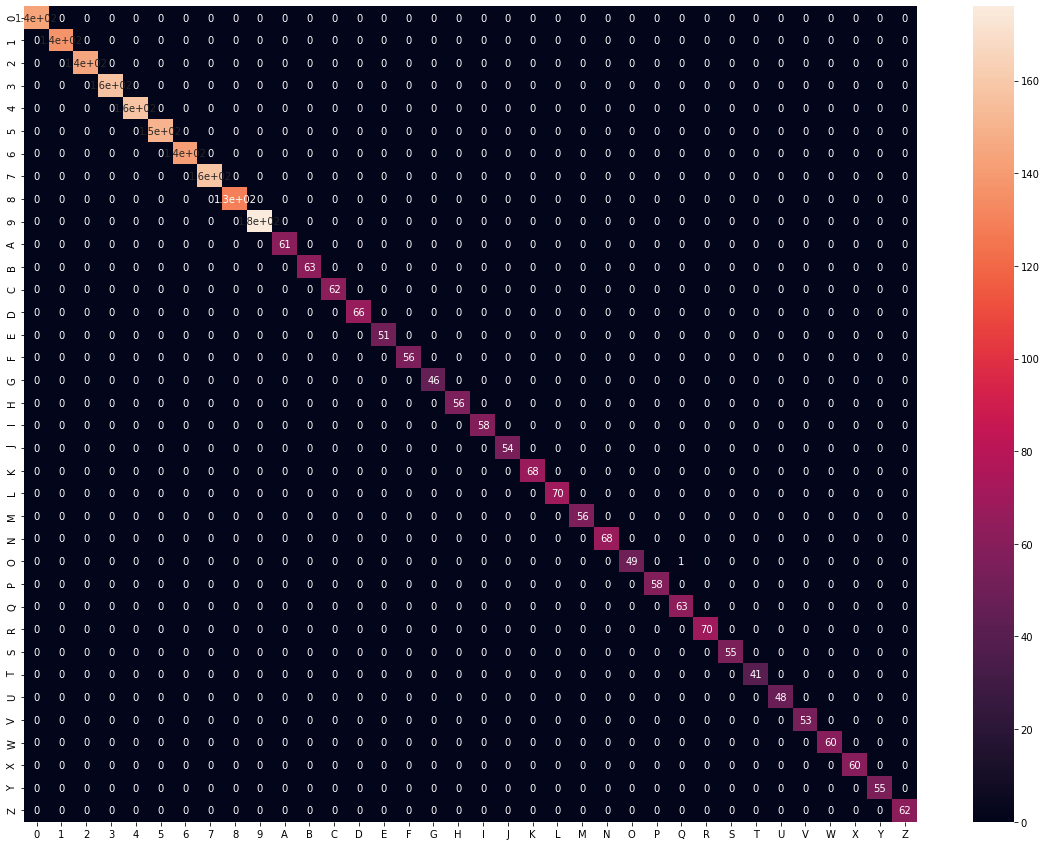

In [65]:
plotConfusionMatrix()